<a href="https://colab.research.google.com/github/sspradling78/SFAirport/blob/main/ML_Model/SF_Airport_US.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders==2.*
!pip install xgboost


In [ ]:
import pandas as pd
import numpy as np
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Boosted Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 

# Permutation Importance
from sklearn.inspection import permutation_importance 

In [ ]:
def wrangle(filename):
    df = pd.read_csv(filename, parse_dates= ['Activity Period'], index_col= 'Activity Period')
    
    df.drop(columns= ['Unnamed: 0', 'Operating Airline', 'Operating Airline IATA Code',
                  'Published Airline', 'Published Airline IATA Code'], inplace= True)
    
    
    return df

In [ ]:
df = wrangle('Air_Traffic_US.csv')
df.head()

,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,Year,Month
Activity Period,,,,,,,,,
2005-07-01,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271,2005,7
2005-07-01,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131,2005,7
2005-07-01,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415,2005,7
2005-07-01,Domestic,US,Deplaned,Low Fare,International,A,8055,2005,7
2005-07-01,Domestic,US,Enplaned,Low Fare,International,A,7984,2005,7


In [ ]:
target = 'Price Category Code'
y = df[target]
X = df.drop(target, axis= 1)

<AxesSubplot:>

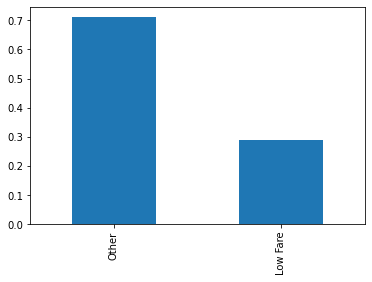

In [ ]:
y.value_counts(normalize= True).plot(kind= 'bar')

In [ ]:
# Training before 2016 & after 2005
train_mask = (X.index.year < 2016) & (X.index.year > 2005)
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

# Validation on 2016 & 2017
validation_mask = (X.index.year == 2017) | (X.index.year == 2016)
X_val, y_val = X.loc[validation_mask], y.loc[validation_mask]

# Testing after 2017, but before 2020
test_mask = (X.index.year > 2017) & (X.index.year < 2020)
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

In [ ]:
baseline_acc = y_train.value_counts(normalize= True).max()
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7000556483027268


In [ ]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_jobs= -1)
)

model_rf.fit(X_train, y_train);

In [ ]:
train_acc = model_rf.score(X_train, y_train)
val_acc = model_rf.score(X_val, y_val)

print('Training Accuracy Score:', train_acc * 100)
print('Validation Accuracy Score:', val_acc * 100)

Training Accuracy Score: 99.98145056575774
Validation Accuracy Score: 93.23383084577115


In [ ]:
model_gb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy= 'mean'),
    GradientBoostingClassifier(random_state= 42, n_estimators= 75)
)

model_gb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['GEO Summary', 'GEO Region',
                                      'Activity Type Code', 'Terminal',
                                      'Boarding Area'],
                                mapping=[{'col': 'GEO Summary',
                                          'data_type': dtype('O'),
                                          'mapping': Domestic    1
NaN        -2
dtype: int64},
                                         {'col': 'GEO Region',
                                          'data_type': dtype('O'),
                                          'mapping': US     1
NaN   -2
dtype: int64},
                                         {'col': 'Activity Type Code',
                                          'data_type': dtype('O'),
                                          'mapping': Dep...
dtype: int64},
                                         {'col': 'Terminal',
                                          'data_type'

In [ ]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy= 'mean'),
    XGBClassifier(random_state= 42, n_estimator= 75, n_jobs= -1)
)

model_xgb.fit(X_train, y_train)

C:\Users\Student\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:30:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:30:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['GEO Summary', 'GEO Region',
                                      'Activity Type Code', 'Terminal',
                                      'Boarding Area'],
                                mapping=[{'col': 'GEO Summary',
                                          'data_type': dtype('O'),
                                          'mapping': Domestic    1
NaN        -2
dtype: int64},
                                         {'col': 'GEO Region',
                                          'data_type': dtype('O'),
                                          'mapping': US     1
NaN   -2
dtype: int64},
                                         {'col': 'Activity Type Code',
                                          'data_type': dtype('O'),
                                          'mapping': Dep...
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_st

In [ ]:
print('Training Accuracy', model_gb.score(X_train, y_train))
print('Validation Accuracy', model_gb.score(X_val, y_val))

Training Accuracy 0.8840660359859024
Validation Accuracy 0.7840796019900498


In [ ]:
print('Training Accuracy', model_xgb.score(X_train, y_train))
print('Validation Accuracy', model_xgb.score(X_val, y_val))

Training Accuracy 0.993322203672788
Validation Accuracy 0.9273631840796019


Text(0, 0.5, 'Feature')

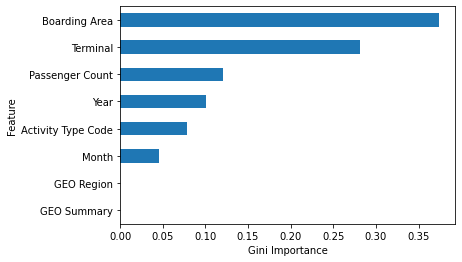

In [ ]:
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(data= importances, index= feature_names).sort_values()
feat_imp.tail(10).plot(kind= 'barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

In [ ]:
col = 'Activity Type Code'

model_w_col = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42,n_estimator=75, n_jobs=-1) #learning rate = 0.01, 0.1,0.2
)

model_w_col.fit(X_train, y_train)


print(model_w_col.score(X_val,y_val))

C:\Users\Student\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9273631840796019


In [ ]:
model_wo_col = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42,n_estimator=75, n_jobs=-1) #learning rate = 0.01, 0.1,0.2
)

model_wo_col.fit(X_train.drop(columns=col), y_train)
print(model_wo_col.score(X_val.drop(columns=col),y_val))

C:\Users\Student\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:44:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8935323383084577


In [ ]:
model_perm = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy= 'mean'),
    XGBClassifier(random_state= 42, n_estimator= 75, n_jobs= -1) #learning rate = 0.01, 0.1,0.2
)

model_perm.fit(X_train, y_train)

C:\Users\Student\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['GEO Summary', 'GEO Region',
                                      'Activity Type Code', 'Terminal',
                                      'Boarding Area'],
                                mapping=[{'col': 'GEO Summary',
                                          'data_type': dtype('O'),
                                          'mapping': Domestic    1
NaN        -2
dtype: int64},
                                         {'col': 'GEO Region',
                                          'data_type': dtype('O'),
                                          'mapping': US     1
NaN   -2
dtype: int64},
                                         {'col': 'Activity Type Code',
                                          'data_type': dtype('O'),
                                          'mapping': Dep...
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_st

In [ ]:
model_perm.score(X_val, y_val)

0.9273631840796019

In [ ]:
X_val_perm = X_val.copy()
X_val_perm[col] = np.random.permutation(X_val_perm[col])

In [ ]:
model_perm.score(X_val_perm, y_val)

0.8920398009950249

In [ ]:
perm_imp = permutation_importance(model_perm, X_val, y_val, random_state= 42)

In [ ]:
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}


df_perm = pd.DataFrame(data_perm, index= X_val.columns).sort_values('imp_mean')

In [ ]:
df_perm

,imp_mean,imp_std
GEO Summary,0.000000,0.000000
GEO Region,0.000000,0.000000
Year,0.000000,0.000000
Month,0.010448,0.005141
Activity Type Code,0.037612,0.000923
Terminal,0.132637,0.004229
Passenger Count,0.184179,0.007502
Boarding Area,0.241393,0.006097
